In [17]:
!pip install pyreadr

In [18]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import pyreadr
import networkx as nx
import numpy as np
import random

# Import Data

In [19]:

data = pyreadr.read_r('dataContact.RData')


pair_df = list(data.values())[0]


pair_df.rename(columns={"ID.x": "ID 1", "ID.y": "ID 2", "DURATION": "Weight", "SAIL": 'Sail', "DAY_INTERACT": "Day"}, inplace=True)


pair_df.head()

,ID 1,ID 2,Weight,CONTACT_TYPE,Sail,Day
0,2555C122B,2AF1C122B,4.0,transient,1,2.0
1,2555C122B,2AF48122B,5.0,transient,1,2.0
2,2555C122B,2AFF4122B,15.0,transient,1,2.0
3,2555C122B,2AFFC122B,16.0,transient,1,2.0
4,2555C122B,2EA64122C,11.0,transient,1,1.0


## Duration / Weight 

transient: less than 5min = 300s  
casual: 5- <=15 min = 300 - 900s  
close: >=15min = 900s

# Raw data

Strength: Sum of weight (total number of contact) 

Degree: Number of individual contacted 

In [20]:

data = pyreadr.read_r('dataNodes.RData')


individual_df = list(data.values())[0]

individual_df.rename(columns={"ID": "ID", "DEGREE": "Degree", "STRENGTH": "Strenth", "EIGEN": 'Eigen', "BETWEEN": 'Between', "CC": 'CC', "SAIL": 'Sail', "DAY_INTERACT": 'Day'}, inplace=True)
individual_df=individual_df.drop(columns=["CABIN_NO", "AGE","GENDER"])
individual_df=individual_df.dropna()

individual_df.head()

,ID,COHORT,TYPE,Sail,Degree,Strenth,Eigen,Between,CC,COMPONENT
0,32058122C,MARINE,C,1.0,210.0,14.342239,0.181351,2103.947731,0.156163,1
1,3202A122C,MARINE,C,1.0,66.0,6.639613,0.034154,215.584662,0.294185,1
3,31EE5122C,MARINE,C,1.0,42.0,6.553090,0.023431,66.210250,0.375920,1
4,3219E122C,MARINE,C,1.0,37.0,4.302573,0.021843,45.105273,0.353108,1
5,3229F122C,MARINE,C,1.0,51.0,5.953401,0.019117,82.777641,0.300677,1


# Choose Dataset

### possible resolution  
1. transient + casual + close  : ALL  
2. casual + close  : >300s  
3. transient  : >900s

In [21]:
#1. choose a ship
pair1_df = pair_df[ (pair_df["Sail"]==1)]

#2. choose a resolution
#casual_df = pair1_df[(pair1_df["CONTACT_TYPE"] == "close")|(pair1_df["CONTACT_TYPE"] == "casual")|(pair1_df["CONTACT_TYPE"] == "transient")]
casual_df = pair1_df[(pair1_df["CONTACT_TYPE"] == "close")]

#3. only want day 2 (the only FULL day) --> no satuation and used the simplified formula
casual_df = casual_df[(casual_df['Day']==2.0)]
casual_df

#ignored cohort for now as only focusing on pure interaction

,ID 1,ID 2,Weight,CONTACT_TYPE,Sail,Day
8,2555C122B,2EBD7122C,1110.0,close,1,2.0
9,2555C122B,2EBD7122C,2686.0,close,1,2.0
10,2555C122B,2EBD7122C,2627.0,close,1,2.0
11,2555C122B,2EBD7122C,2857.0,close,1,2.0
12,2555C122B,2EBD7122C,1506.0,close,1,2.0
...,...,...,...,...,...,...
1367538,415B3122C,4159A122C,900.0,close,1,2.0
1367539,415B3122C,4159A122C,1200.0,close,1,2.0
1367540,415B3122C,4159A122C,900.0,close,1,2.0
1367541,415B3122C,4159A122C,1200.0,close,1,2.0


In [22]:
casual_df['Weight'].sum()

156248508.0

##  simulation parameter  
**unit**  
beta: depends on the formula used (e.g. when beta = 0.001, P of transmission for Weight=1 interaction is 0.001 --> 0.1% small)

In [23]:
beta = 0.0029  # From Smith et al. 2020 Cruise Ship Study
sigma = 1.0  # Susceptibility

#exposure_duration = 2  # Time steps before moving from E to I



1. create graph  


2. add weight (edge) using weight in the dataset  


3. choose the biggest connect sub-graph inside the whole graph and pick 3 S-I individual 
(connected graph is used to ensure the picked individual is not isolated from others in the graph)  


4. define exposed duration + infected duration for each individual using gamma distribution (parameter taken from main research paper)

no time thus using sum of weight 

In [24]:
aggregated_weights = (
    casual_df.groupby(['ID 1', 'ID 2'])['Weight']
    .sum()
    .reset_index()
)

# Create the graph and add edges with summed weights
graph = nx.Graph()
for _, row in aggregated_weights.iterrows():
    graph.add_edge(row["ID 1"], row["ID 2"], weight=row["Weight"])


largest_component = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_component).copy()

# Initialize all individuals as S
individual_states = {node: "S" for node in graph.nodes}

initial_infected = np.random.choice(list(graph.nodes), size=3, replace=False)

# Set I
for node in initial_infected:
    individual_states[node] = "I"

 # Shape=3, Scale=4/3 days (Lloyd-Smith 2007)
exposure_durations = {node: np.random.gamma(3, 4/3) for node in graph.nodes}  # on average take 3 days from E to I

infectious_durations = {node: np.random.gamma(6, 5/6) for node in graph.nodes} # on avg take 6 days from I to R

#calculating average contact per person 
contact_counts = [len(list(graph.neighbors(node))) for node in graph.nodes]
average_contacts = sum(contact_counts)/len(contact_counts)
max_contacts = max(contact_counts)
min_contacts = min(contact_counts)

print("\nContact Network Statistics:")
print(f"- Total individuals: {len(graph.nodes)}")
print(f"- Average contacts per individual: {average_contacts:.2f}")
print(f"- Maximum contacts: {max_contacts}")
print(f"- Minimum contacts: {min_contacts}")

# Initialize exposure tracking
cumulative_exposure = {node: 0 for node in graph.nodes}

# Calculate average contact duration (weights in seconds)
total_contact_times = [
    sum(graph[node][neighbor]['weight'] for neighbor in graph.neighbors(node)) 
    for node in graph.nodes
]
average_contact_duration = np.mean(total_contact_times)  # In seconds
mean_infectious_days = 6 * (5/6)
seconds_per_day = 86400
average_daily_contact = average_contacts / seconds_per_day
# Suppose we have:
beta_per_day = 250
mean_infectious_days = 5.0
total_contact_times_days = [
    sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node)) / 86400.0
    for node in graph.nodes
]
average_contact_duration_days = np.mean(total_contact_times_days)

R0 = (1 - np.exp(-beta_per_day * average_contact_duration_days)) * mean_infectious_days

print(f"- Using R₀ = (1 - exp(-β × c)) × D: {R0:.2f}")

max_total_contact_times = max(total_contact_times)
min_total_contact_times = min(total_contact_times)
print(f"- avg weight: {average_contact_duration}")
print(f"- Maximum total_contact_times: {max_total_contact_times}")
print(f"- Minimum total_contact_times: {min_total_contact_times}")


Contact Network Statistics:
- Total individuals: 2140
- Average contacts per individual: 16.74
- Maximum contacts: 85
- Minimum contacts: 1
- Using R₀ = (1 - exp(-β × c)) × D: 5.00
- avg weight: 72637.06635514018
- Maximum total_contact_times: 504614.0
- Minimum total_contact_times: 901.0


In [25]:
def calculate_R0(graph, beta, mean_infectious_duration_days):
    total_weights = [sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
                     for node in graph.nodes]
    average_contact_duration_seconds = np.mean(total_weights)
    mean_infectious_duration_seconds = mean_infectious_duration_days * 86400.0
    R0 = (1 - np.exp(-beta * average_contact_duration_seconds)) * mean_infectious_duration_seconds
    return R0

calculate_R0(graph, beta, 432000)

37324800000.0

## PCR 


Infected individual will have 95% tested positive and 5% tested negative **(false negative)**  

Susceptible individual will have 98% tested negative and 2% tested positive **(false positive)**  


In [26]:
import random

def pcr_test(individual_states, sensitivity=0.95, specificity=0.98):
    updated_states = individual_states.copy()
    PCR_state = {}
    global cumulative_pcr
    cumulative_pcr += len(individual_states)

    for node, state in individual_states.items():
        rand_val = random.random()
        if state == "I":
            # Infected: true positive with probability sensitivity.
            PCR_state[node] = 1 if rand_val < sensitivity else 0
        elif state in ["S", "E"]:
            # Susceptible/Exposed: false positive with probability (1 - specificity).
            PCR_state[node] = 1 if rand_val < (1 - specificity) else 0
        else:
            # For any other state (if any), default to negative.
            PCR_state[node] = 0

    return updated_states, PCR_state

## quarantine

In [27]:
quarantine_state = {node: 0 for node in graph.nodes}  # 1 for in quarantine, 0 for not
consecutive_PCR = {node: 0 for node in graph.nodes}  # Track consecutive negative PCR tests
exposure_quarantine_threshold = 900 #duration/weight hit this number then nd to quarantine
had_positive_PCR = {node: False for node in graph.nodes}
quarantine_testing_method = "new"  # "new" or "original"
vaccination_reason = {node: None for node in graph.nodes}  # Track why someone was vaccinated
vaccine_effectiveness = {node: 0.0 for node in graph.nodes}  # Track individual vaccine effectiveness
days_since_vaccination = {node: -1 for node in graph.nodes}  # Track days since vaccination
cumulative_pcr = 0  # Track total PCR tests used

In [28]:
def quarantine(
    individual_states,
    quarantine_state,
    time_exposed,
    time_infectious,
    consecutive_PCR,
    had_positive_PCR,
    pcr_result=None,
    sensitivity=0.95,
    specificity=0.98,
    exposure_threshold=3,
    quarantine_threshold=7, #max quarantine days
    exposure_durations=None,
    infectious_durations=None,
    use_new_testing_method=False,
    new_testing_method_frequency=1
):
    """
    update quarantine state (once in quarantine, not in transmission loop)

    quarantine condition: 
    1. weight > exposure duration
    2. PCR positive 

    release condition: 
    1. hit consecutive quarantine_threshold (all -ve throughout)

    release as S is ALL -ve during quarantine
    release as R is at least ONE +ve during quarantine

    sequence: 
    1. check weight for ALL regardless of quarantine -> may go quarantine
    2. test PCR everyday in quarantine
    3. +ve -> go quarantine 
    4. -ve -> check release condition
    """
    updated_quarantine_state = quarantine_state.copy()
    updated_consecutive_PCR = consecutive_PCR.copy()
    updated_had_positive_PCR = had_positive_PCR.copy()
    updated_states = individual_states.copy()
    global cumulative_pcr
    
    # Initialize counters for logging
    quarantine_entries_pcr = 0
    quarantine_entries_exposure = 0
    quarantine_releases = 0

    for node in individual_states.keys():
        if quarantine_state[node] == 0:  # Not in quarantine
            # Check if individual should enter quarantine
            if pcr_result is not None and pcr_result.get(node, 0) == 1:
                updated_quarantine_state[node] = 1
                updated_consecutive_PCR[node] = 0
                updated_had_positive_PCR[node] = True
                quarantine_entries_pcr += 1  # Count PCR-based entries
            elif time_exposed[node] > exposure_threshold:
                updated_quarantine_state[node] = 1  # Enter quarantine
                updated_consecutive_PCR[node] = 0  # Reset PCR counter
                updated_had_positive_PCR[node] = False  # Reset positive PCR flag
                quarantine_entries_exposure += 1  # Count exposure-based entries

        elif quarantine_state[node] == 1:  # In quarantine
            # Progress through states while in quarantine
            if individual_states[node] == "E":  # Exposed
                time_exposed[node] += 1
                if time_exposed[node] >= exposure_durations[node]:
                    updated_states[node] = "I"  # Become Infectious
                    time_infectious[node] = 0
            elif individual_states[node] == "I":  # Infectious
                time_infectious[node] += 1
                if time_infectious[node] >= infectious_durations[node]:
                    updated_states[node] = "R"  # Recover
            current_state = updated_states[node]
            
            # Perform PCR testing for quarantined individual
            if use_new_testing_method:
                # New testing method implementation
                updated_consecutive_PCR[node] += 1  # Increment days in quarantine
                
                if updated_consecutive_PCR[node] % new_testing_method_frequency == 0:  # Test on 7th day
                    _, quarantine_PCR_state = pcr_test(
                        {node: current_state},
                        sensitivity=sensitivity,
                        specificity=specificity
                    )
                    cumulative_pcr += 1
                    
                    if quarantine_PCR_state[node] == 1:  # Positive test
                        updated_had_positive_PCR[node] = True
                        updated_consecutive_PCR[node] = 0  # Reset counter
                        #updated_states[node] = "I"
                    else:  # Negative test on 7th day
                        #updated_consecutive_PCR[node] += 1
                        if updated_consecutive_PCR[node] >= quarantine_threshold:
                            updated_quarantine_state[node] = 0  # Exit quarantine
                            quarantine_releases += 1
                            if updated_states[node] == "R":
                                pass
                            elif updated_had_positive_PCR[node]:
                                updated_states[node] = "R"  
                            else:
                                updated_states[node] = "S"
            else:
                # Original testing method: test daily
                _, quarantine_PCR_state = pcr_test(
                    {node: current_state},
                    sensitivity=sensitivity,
                    specificity=specificity
                )
                cumulative_pcr += 1
                
                if quarantine_PCR_state[node] == 1:  # Positive test
                    updated_consecutive_PCR[node] = 0  # Reset counter
                    updated_had_positive_PCR[node] = True
                    #updated_states[node] = "I"
                else:  # Negative test
                    updated_consecutive_PCR[node] += 1
                    if updated_consecutive_PCR[node] >= quarantine_threshold:
                        updated_quarantine_state[node] = 0  # Exit quarantine
                        quarantine_releases += 1
                        if updated_states[node] == "R":
                            pass
                        elif updated_had_positive_PCR[node]:
                            updated_states[node] = "R"  
                        else:
                            updated_states[node] = "S"

    # Print logging information
    #print(f"Quarantine entries (PCR): {quarantine_entries_pcr}, Entries (Exposure): {quarantine_entries_exposure}, Releases: {quarantine_releases}")

    return (
        updated_quarantine_state,
        updated_consecutive_PCR,
        updated_had_positive_PCR,
        updated_states,
    )

# vaccination

**1. Calculate decay rate**  

$$
\lambda = -\frac{\ln(1 - \text{Efficacy})}{T}
$$

Efficacy: initial vaccine efficacy (e.g. 0.5 for 50% reduction in susceptibility)
T is the waning period in days (e.g. 180 days)  
1st day vaccination: susceptibility reduce by 0.5  
slowly increase susceptibility exponentially till 1 in 180 days  

**2. Calculate susceptibility : Waning Immunity**  
susceptibility after vaccination
$$
\text{Susceptibility}(t) = 1 - (1 - \text{Efficacy}) \cdot e^{-\lambda t}
$$

t is the time since vaccination in days

In [29]:


def mass_vaccinate(
    individual_states,
    vaccination_status,
    vaccination_start_time,
    susceptibility,
    r_values,
    time_step,
    rollout_rate=0.02,                # 2% of the total population per day
    coverage_threshold=0.8,           # Stop if 80% of the population is vaccinated
    vaccination_efficacy=0.8,         # 80% reduction in susceptibility
    r_reduction=0.5                   # 50% reduction in infectiousness if breakthrough occurs
):
    """
    Apply mass vaccination: vaccinate individuals in S and E compartments.
    - The rollout_rate determines that 2% of the total population is vaccinated per day.
    - Vaccination stops when overall vaccination coverage reaches the coverage_threshold.
    """
    total_population = len(individual_states)
    current_coverage = sum(vaccination_status.values()) / total_population
    if current_coverage >= coverage_threshold:
        # Vaccination stops when the overall coverage threshold is reached.
        return vaccination_status, susceptibility, r_values

    # Determine the target number to vaccinate for today.
    target_num = int(rollout_rate * total_population)
    
    # Identify eligible individuals (in S or E compartments and not already vaccinated).
    eligible_nodes = [node for node, state in individual_states.items()
                      if (not vaccination_status[node]) and (state in ["S", "E"])]
    
    # Vaccinate a random subset up to the daily target.
    num_to_vaccinate = min(target_num, len(eligible_nodes))
    nodes_to_vaccinate = np.random.choice(eligible_nodes, size=num_to_vaccinate, replace=False)
    
    for node in nodes_to_vaccinate:
        vaccination_status[node] = True
        vaccination_start_time[node] = time_step
        # Update protection: reduce susceptibility and r_value.
        susceptibility[node] *= (1 - vaccination_efficacy)
        r_values[node] *= r_reduction

    return vaccination_status, susceptibility, r_values


def ring_vaccinate(
    individual_states,
    vaccination_status,
    vaccination_start_time,
    susceptibility,
    r_values,
    time_step,
    rollout_rate=0.02,                # Use rollout rate to vaccinate 2% of total population per day (applied to eligible contacts)
    coverage_threshold=0.8,           # Overall vaccination threshold for stopping vaccination
    vaccination_efficacy=0.8,         # 80% reduction in susceptibility
    r_reduction=0.5                   # 50% reduction in infectiousness if breakthrough occurs
):
    """
    Apply ring vaccination: vaccinate individuals only in the Exposed (E) compartment.
    This function vaccinates a daily target number (rollout_rate * total population)
    of exposed individuals (E) if they haven't been vaccinated yet.
    """
    total_population = len(individual_states)
    current_coverage = sum(vaccination_status.values()) / total_population
    if current_coverage >= coverage_threshold:
        # Stop if overall vaccination coverage is reached.
        return vaccination_status, susceptibility, r_values

    # Determine today's target number.
    target_num = int(rollout_rate * total_population)
    
    # Identify eligible nodes: those in the "E" compartment who haven't been vaccinated.
    eligible_nodes = [node for node, state in individual_states.items()
                      if (not vaccination_status[node]) and (state == "E")]
    
    # Vaccinate a random subset of eligible individuals up to the target number.
    num_to_vaccinate = min(target_num, len(eligible_nodes))
    nodes_to_vaccinate = np.random.choice(eligible_nodes, size=num_to_vaccinate, replace=False)
    
    for node in nodes_to_vaccinate:
        vaccination_status[node] = True
        vaccination_start_time[node] = time_step
        susceptibility[node] *= (1 - vaccination_efficacy)
        r_values[node] *= r_reduction

    return vaccination_status, susceptibility, r_values


def vaccinate(
    individual_states,
    vaccination_status,
    vaccination_start_time,
    susceptibility,
    r_values,
    time_step,
    rollout_rate=0.02,                # 2% rollout per day
    coverage_threshold=0.8,           # Stop when 80% coverage is reached
    vaccination_efficacy=0.8,
    r_reduction=0.5,
    strategy="mass"                 # "mass" for mass vaccination, "ring" for ring vaccination
):
    """
    Wrapper for vaccination that applies either mass or ring vaccination strategy.
    """
    if strategy == "mass":
        return mass_vaccinate(
            individual_states=individual_states,
            vaccination_status=vaccination_status,
            vaccination_start_time=vaccination_start_time,
            susceptibility=susceptibility,
            r_values=r_values,
            time_step=time_step,
            rollout_rate=rollout_rate,
            coverage_threshold=coverage_threshold,
            vaccination_efficacy=vaccination_efficacy,
            r_reduction=r_reduction
        )
    elif strategy == "ring":
        return ring_vaccinate(
            individual_states=individual_states,
            vaccination_status=vaccination_status,
            vaccination_start_time=vaccination_start_time,
            susceptibility=susceptibility,
            r_values=r_values,
            time_step=time_step,
            rollout_rate=rollout_rate,
            coverage_threshold=coverage_threshold,
            vaccination_efficacy=vaccination_efficacy,
            r_reduction=r_reduction
        )
    else:
        raise ValueError("Invalid vaccination strategy. Choose 'mass' or 'ring'.")

use cohort 

**S to E**  

$$
p = 1 - \exp(-\sigma relative infectiouness \cdot \beta \cdot w)
$$  


unit  
beta: probability of transmission per hour of contact  
different for wearing mask / vaccine

**E to I & I to R**   
Gamma distribution  

*choose NPI here*

*vaccinate* every 180 days

In [30]:
time_exposed = {node: -1 for node in graph.nodes}
time_infectious = {node: -1 for node in graph.nodes}
global total_pcr_tests
total_pcr_tests = 0
total_vaccinations = 0

vaccination_status = {node: False for node in graph.nodes}  # Track who is vaccinated
vaccination_start_time = {node: None for node in graph.nodes}  # Track when individuals are vaccinated

PCR_state = {node: 0 for node in graph.nodes}  # current PCR state
prev_PCR_state = {node: 0 for node in graph.nodes} 

last_pcr_test = {node: -1 for node in graph.nodes}
pcr_testing_frequency = 1  # Test every 7 days or 1 for daily
pcr_testing_percentage = 0.5 # Test 20% of population

sensitivity=0.6
specificity=0.98

vaccination_coverage=0.6
vaccination_efficacy=0.9
r_reduction=0.5


pcr_active = True
quarantine_active = True
vaccination_active = False
strategy = "mass" 
quarantine_testing_method = False #false = test everyday, true = test every 7 days
pcr_frequency_in_quarantine = 1 
  
time_steps = 600  # 1 year


susceptibility = {node: 1.0 for node in graph.nodes}  
r_values = {node: 1.0 for node in graph.nodes}

total_infected = set()
state_transition_log = []

# Define day-wise weight scaling (for partial days)
#day_weight_scaling = {1: 0.5, 2: 1.0, 3: 0.33}  # Day 1 = 50%, Day 3 = 33%, Day 2 = full day

# Track recovery time
all_recovered_time = -1  


for t in range(time_steps): 
    # Determine the current day
    #current_day = (t % 3) + 1  # Cycle through Day 1, 2, 3
    #scaling_factor = day_weight_scaling[current_day]  # Adjust weights for the current day

    if quarantine_active:
        quarantine_state, consecutive_PCR, had_positive_PCR, individual_states = quarantine(
            individual_states=individual_states,
            quarantine_state=quarantine_state,
            time_exposed=time_exposed,
            time_infectious=time_infectious,
            consecutive_PCR=consecutive_PCR,
            had_positive_PCR=had_positive_PCR,
            pcr_result=PCR_state,  # if available from previous PCR testing
            sensitivity=sensitivity,
            specificity=specificity,
            exposure_threshold=exposure_quarantine_threshold,
            quarantine_threshold=7,
            exposure_durations=exposure_durations,
            infectious_durations=infectious_durations,
            use_new_testing_method=quarantine_testing_method,
            new_testing_method_frequency=pcr_frequency_in_quarantine
        )
        # The quarantine function already increments cumulative_pcr internally when a PCR is performed.

    if vaccination_active:
                    
        # Capture the number of vaccinated individuals before and after calling vaccinate.
        prev_vaccinated = sum(1 for v in vaccination_status.values() if v)
        vaccination_status, susceptibility, r_values = vaccinate(
            individual_states,
            vaccination_status,
            vaccination_start_time,
            susceptibility,
            r_values,
            t,
            rollout_rate=0.02,
            coverage_threshold=vaccination_coverage,
            vaccination_efficacy=vaccination_efficacy,
            r_reduction=r_reduction,
            strategy=strategy
        )
        new_vaccinations = sum(1 for v in vaccination_status.values() if v) - prev_vaccinated
        if new_vaccinations > 0:
            total_vaccinations += new_vaccinations

    # Disease transmission logic
    new_states = individual_states.copy()
    for node in graph.nodes:
        if quarantine_state[node] > 0:  # If quarantine_state > 0, the individual is in quarantine
            continue
        elif individual_states[node] == "S":  # Susceptible individuals
            for neighbor in graph.neighbors(node):
                if quarantine_state[neighbor] > 0:
                    continue
                elif individual_states[neighbor] == "I":  # Infectious neighbor

                    #weight = graph[node][neighbor]['weight'] * scaling_factor  # Scale weight for partial day
                    weight = graph[node][neighbor]['weight']
                    cumulative_exposure[node] += weight
                    infection_prob = 1 - np.exp(-susceptibility[node] * beta * r_values[neighbor] * weight)
                    if np.random.rand() < infection_prob:
                        new_states[node] = "E"  # Exposed
                        time_exposed[node] = 0
                        break

        elif individual_states[node] == "E":  # Exposed individuals
            time_exposed[node] += 1
            if time_exposed[node] >= exposure_durations[node]:
                new_states[node] = "I"  # Infectious
                time_infectious[node] = 0

        elif individual_states[node] == "I":  # Infectious individuals
            total_infected.add(node)
            time_infectious[node] += 1
            if time_infectious[node] >= infectious_durations[node]:
                new_states[node] = "R"  # Recovered

    # Update individual states
    individual_states = new_states.copy()
    state_transition_log.append({
        "individual_states": individual_states.copy(),
        "quarantine_state": quarantine_state.copy(),  # Log quarantine state
    })
    
    if pcr_active:
        should_test_today = (pcr_testing_frequency == 1) or (t % pcr_testing_frequency == 0)
        if should_test_today:
            # Select 20% of the population randomly
            eligible_nodes = [node for node in graph.nodes 
                            if quarantine_state[node] == 0]  # Only test non-quarantined individuals
            sample_size = int(len(eligible_nodes) * pcr_testing_percentage)
            nodes_to_test = np.random.choice(eligible_nodes, 
                                            size=sample_size, 
                                            replace=False) if eligible_nodes else []
            
            # Create a subset dictionary for the selected nodes
            test_states = {node: individual_states[node] for node in nodes_to_test}
            
            # Perform PCR test on selected subset
            if test_states:
                _, PCR_state_subset = pcr_test(test_states, sensitivity, specificity)
                
                # Update the overall PCR state dictionary
                # Initialize with zeros for all nodes
                PCR_state = {node: 0 for node in graph.nodes}
                # Update with test results for tested nodes
                for node in nodes_to_test:
                    PCR_state[node] = PCR_state_subset[node]
                    last_pcr_test[node] = t
                    
                # Update the global PCR test counter
                cumulative_pcr += len(nodes_to_test)
    #prev_PCR_state = PCR_state.copy()
    # Early stopping condition: Track time when all individuals recover
    if all(state == "R" or state == "S" for state in individual_states.values()):
        all_recovered_time = t
        print(f"All individuals recovered by timestep {t}.")
        break



print("Simulation Outcomes:")
print(f"- Time for all individuals to recover: {all_recovered_time} time steps")
print(f"- Total number of individuals infected: {len(total_infected)}")
print(f"- Total simulation time steps: {len(state_transition_log)}")

avg_total_exposure = sum(cumulative_exposure.values())/len(cumulative_exposure)
max_exposure = max(cumulative_exposure.values())
min_exposure = min(cumulative_exposure.values())

print("\nExposure Statistics:")
print(f"- Average cumulative exposure: {avg_total_exposure:.2f} seconds")
print(f"- Maximum individual exposure: {max_exposure:.2f} seconds")
print(f"- Minimum individual exposure: {min_exposure:.2f} seconds")

print(f"Total PCR tests used: {cumulative_pcr}")
print(f"Final vaccination coverage: {sum(vaccination_status.values())/len(vaccination_status)*100:.1f}%")

All individuals recovered by timestep 55.
Simulation Outcomes:
- Time for all individuals to recover: 55 time steps
- Total number of individuals infected: 1252
- Total simulation time steps: 56

Exposure Statistics:
- Average cumulative exposure: 3859.53 seconds
- Maximum individual exposure: 93136.00 seconds
- Minimum individual exposure: 0.00 seconds
Total PCR tests used: 136926
Final vaccination coverage: 0.0%


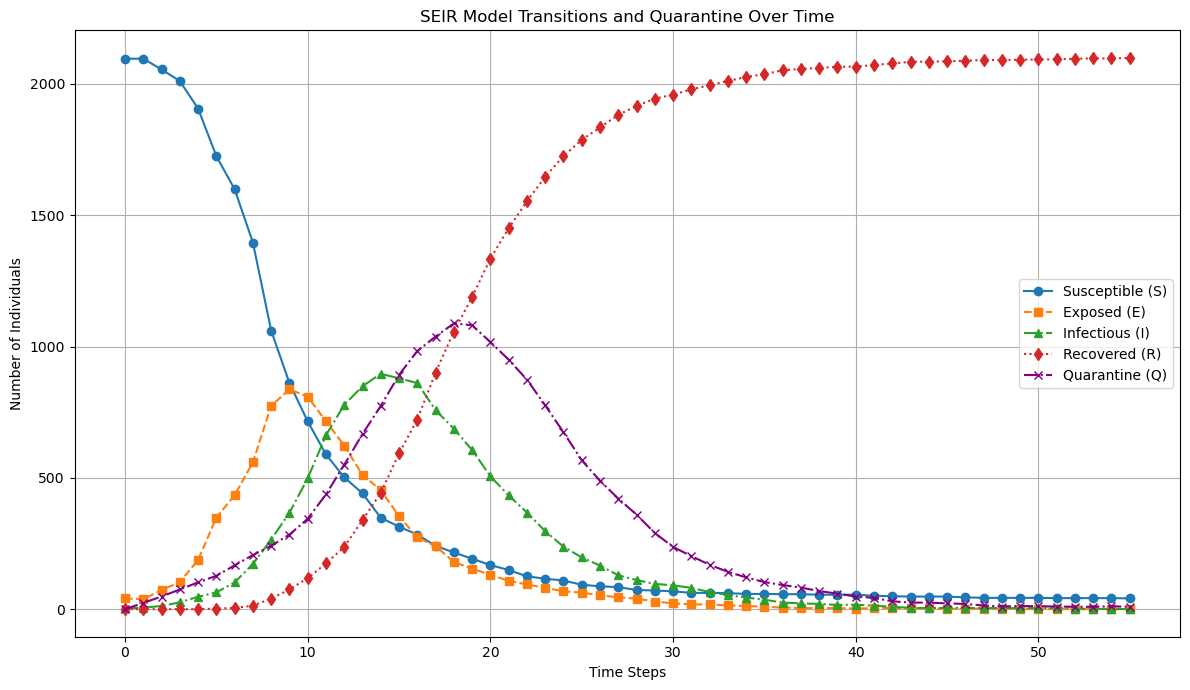

In [31]:


# Step 1: Extract counts from the state transition log
# Initialize lists to track counts over time
s_counts, e_counts, i_counts, r_counts, q_counts = [], [], [], [], []

for log in state_transition_log:
    state_snapshot = log["individual_states"]
    quarantine_snapshot = log["quarantine_state"]

    s_counts.append(sum(1 for state in state_snapshot.values() if state == "S"))
    e_counts.append(sum(1 for state in state_snapshot.values() if state == "E"))
    i_counts.append(sum(1 for state in state_snapshot.values() if state == "I"))
    r_counts.append(sum(1 for state in state_snapshot.values() if state == "R"))
    q_counts.append(sum(1 for state in quarantine_snapshot.values() if state == 1))  # Count quarantined individuals

# Step 2: Plot the SEIR transitions and Quarantine counts
time_steps = range(len(state_transition_log))

plt.figure(figsize=(12, 7))

# Plot each state
plt.plot(time_steps, s_counts, label="Susceptible (S)", linestyle="-", marker="o")
plt.plot(time_steps, e_counts, label="Exposed (E)", linestyle="--", marker="s")
plt.plot(time_steps, i_counts, label="Infectious (I)", linestyle="-.", marker="^")
plt.plot(time_steps, r_counts, label="Recovered (R)", linestyle=":", marker="d")
plt.plot(time_steps, q_counts, label="Quarantine (Q)", linestyle="dashdot", marker="x", color="purple")

# Add labels, legend, and grid
plt.title("SEIR Model Transitions and Quarantine Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Number of Individuals")
plt.legend(loc="best")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [32]:
# Assume that state_transition_log is a list of snapshots collected over time
# and that s_counts, e_counts, i_counts, r_counts have been computed as in your code.

# Calculate total population (assuming it is constant)
total_population = len(state_transition_log[0]["individual_states"])

# --- Final Outbreak Size ---
# One way to define the final outbreak size is to consider all individuals who were ever infected.
# Here, we assume that if an individual did NOT remain Susceptible, they were infected.
# Alternatively, if the epidemic runs its full course, you can use:
final_susceptible = s_counts[-1]
final_outbreak_size = total_population - final_susceptible
print("Final outbreak size:", final_outbreak_size)

# --- Peak Infecting Time ---
# Find the time step where the number of Infectious individuals is maximum.
peak_infecting = max(i_counts)
peak_infecting_time = i_counts.index(peak_infecting)  # index corresponds to time step
print("Peak infecting time (time step):", peak_infecting_time)
print("Peak number of infectious individuals:", peak_infecting)

# --- Time for All to Recover ---
# We define this as the first time step where there are no Exposed (E) and no Infectious (I) individuals.
all_recovered_time = None
for t, (e, i) in enumerate(zip(e_counts, i_counts)):
    if e == 0 and i == 0:
        all_recovered_time = t
        break

if all_recovered_time is not None:
    print("Time for all to recover (time step):", all_recovered_time)
else:
    print("Not all individuals have recovered by the end of the simulation.")

Final outbreak size: 2099
Peak infecting time (time step): 14
Peak number of infectious individuals: 896
Time for all to recover (time step): 55


unit for days (check the paper)  
unit for parameter   
check vaccine period and suscepibility will change (take effect after 14 days)  
assumption: no mutation 

adjust beta!!!  
vaccine crew first  
vaccinate on the first day???

QN:  
Recovered individual infected again?  
sum up weight for all pair or use more than 1 edges  
include relative infectiousness? e.g. when vaccinated, will reduce transmission probability to others  